# Google Colab (Skip locally)

In [3]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/gdrive


In [4]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135/HW3_2025/src" #@param {type:"string"}
!ln -Ts "$folder" /content/src 2> /dev/null

folder2 = "/content/gdrive/MyDrive/IFT6135/HW3_2025/src/results"
!ln -Ts "$folder2" /content/results 2> /dev/null

# Add the assignment folder to Python path
if '/content/src' not in sys.path:
  sys.path.insert(0, '/content/src')

if '/content/results' not in sys.path:
  sys.path.insert(0, '/content/results')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

# Imports & Setup

In [17]:
%matplotlib inline
import warnings
from shutil import make_archive
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
import random

from q1_train_vae import experiment1
from q2_trainer_ddpm import experiment2
from q3_trainer_cfg import experiment3

models = ['VAE', 'DDPM', 'CFG']

from q1_plots_vae import generate_images, plot_loss, plot_traversals, generate_latent_traversals, plot_interpolation_comparison
from q2_plots_ddpm import plot_samples_across_epochs
from q3_plots_cfg import plot_evolution_across_epochs

# Experiments

## Experiment 1 (VAE)

In [ ]:
vae_model, vae_optimizer = experiment1(False)
dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())

Loaded checkpoint from epoch 20


Saved loss plot to results/experiment1/loss_curve.png


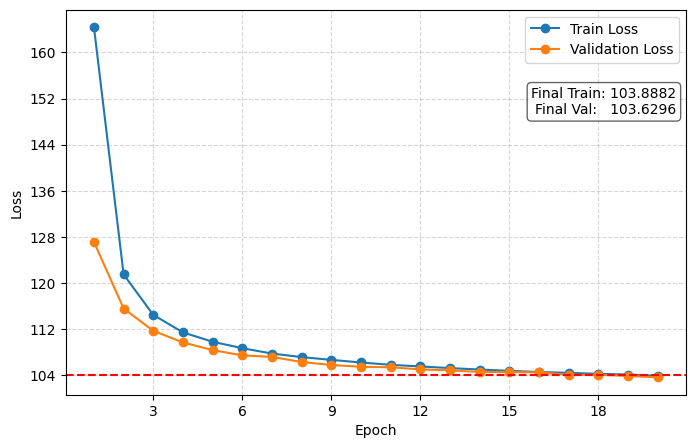

In [ ]:
plot_loss('results/experiment1/history.json', save_path='results/experiment1/loss_curve.png', show=True)

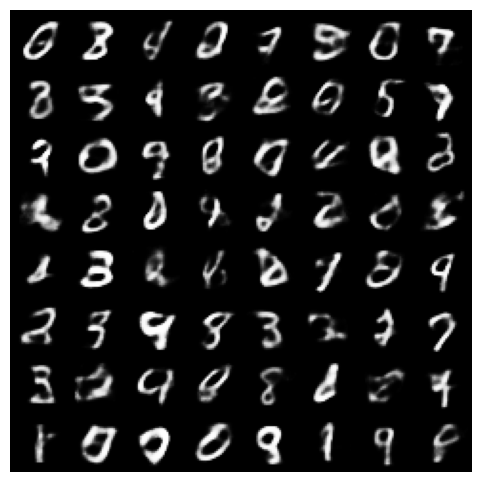

In [ ]:
vae_samples = generate_images(vae_model, num_images=64, show=True, file_path='results/experiment1/vae_samples.png')

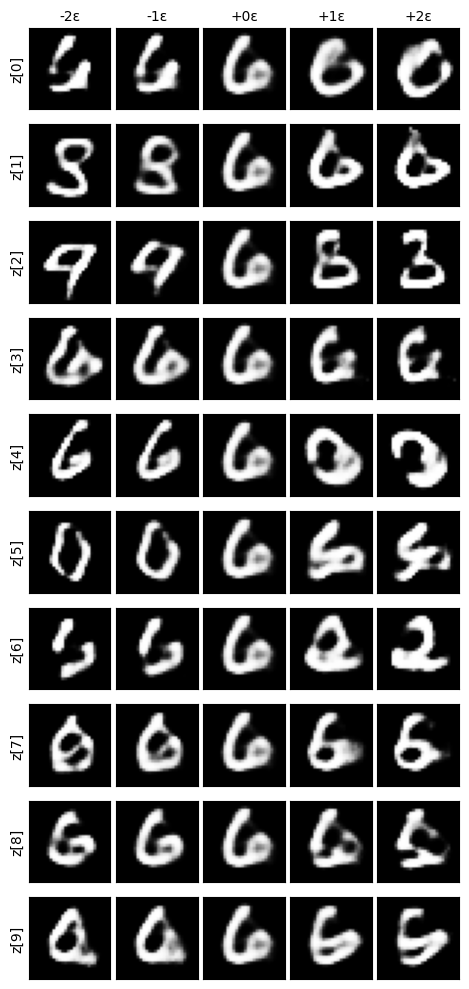

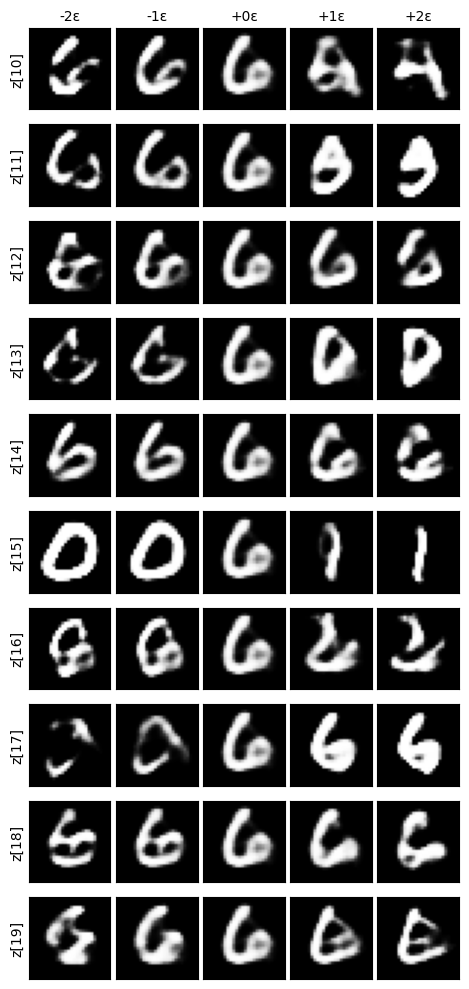

In [ ]:
rand_idx = random.randint(0, len(dataset) - 1)
datapoint, _ = dataset[rand_idx]

eps = 4.0
tr_dp = generate_latent_traversals(vae_model, n_factors=20, n_steps=5, eps=eps, data_sample=datapoint)
plot_traversals(tr_dp, eps=eps, save_path='results/experiment1/traversals_dp.png', show=True)

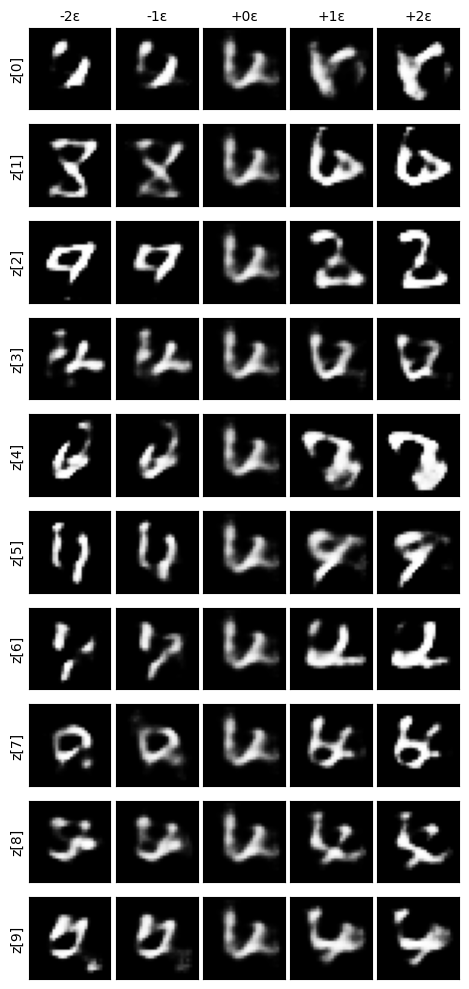

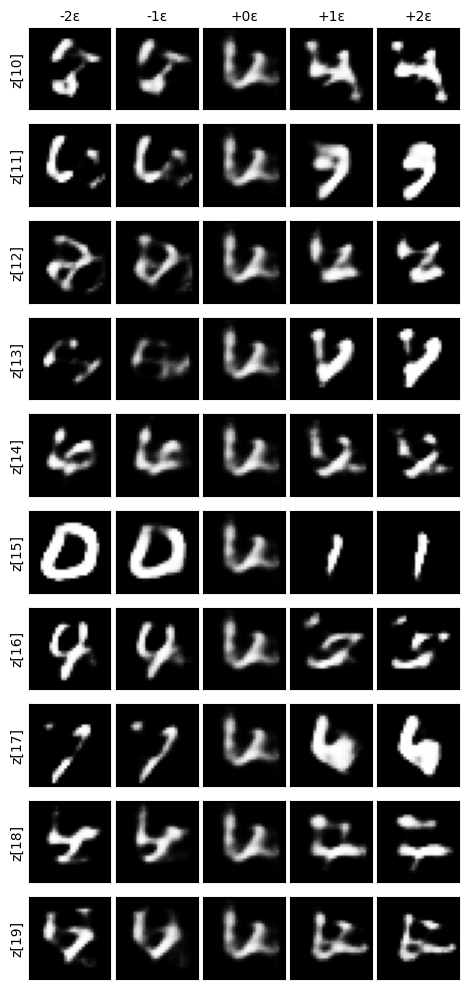

In [ ]:
tr_gs = generate_latent_traversals(vae_model, n_factors=20, n_steps=5, eps=eps)
plot_traversals(tr_gs, eps=eps, save_path='results/experiment1/traversals_gs.png', show=True)

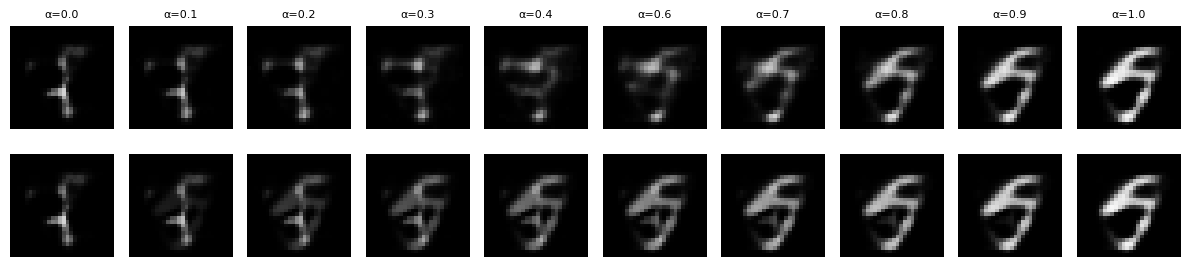

In [ ]:
plot_interpolation_comparison(vae_model, num_steps=10, save_path='results/experiment1/interpolation_gs.png', show=True)

Interpolating between 6 and 8


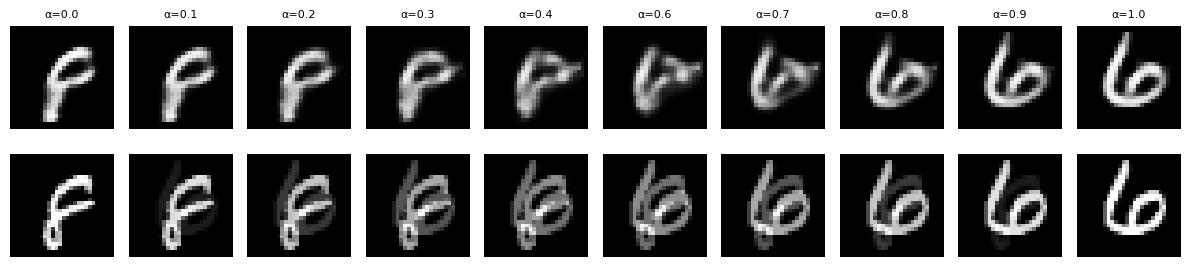

In [ ]:
idx1 = random.randint(0, len(dataset) - 1)
x1, y1 = dataset[idx1]
idx2 = random.randint(0, len(dataset) - 1)
x2, y2 = dataset[idx2]
print(f"Interpolating between {y1} and {y2}")
plot_interpolation_comparison(
    vae_model,
    endpoints=(x1.unsqueeze(0),x2.unsqueeze(0)),
    num_steps=10,
    save_path='results/experiment1/interpolation_ds.png',
    show=True)

## Experiment 2 (DDPM)

In [6]:
ddpm_trainer = experiment2(False)

No weights to load


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.00MB/s]


[Checkpoint] Loaded model at epoch 19 from results/experiment2/checkpoints/ddpm_epoch_019.pt


Sampling: 1000it [00:18, 53.24it/s]


Showing/saving samples from epoch 19


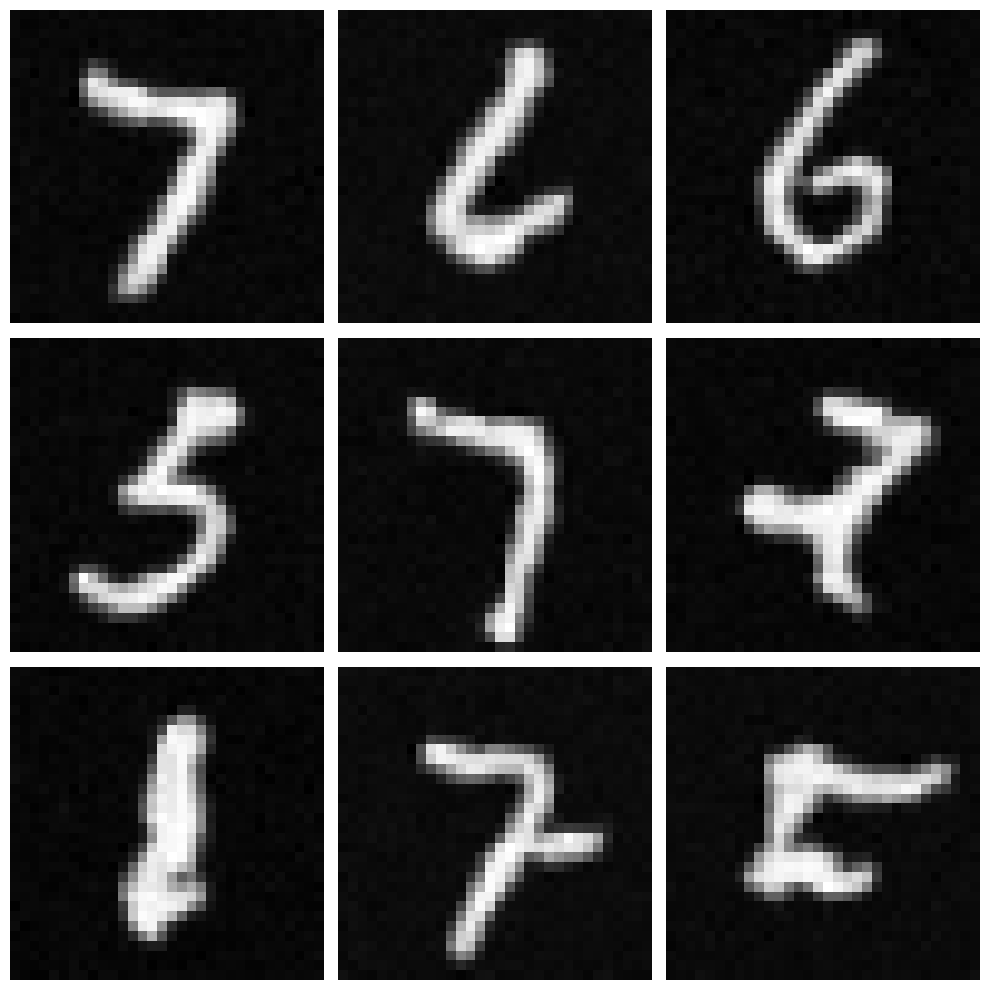

In [7]:
n_samples = 64
n_steps = 1000
ddpm_samples = ddpm_trainer.sample(n_steps=n_steps, n_samples=n_samples, show=True, save=True)

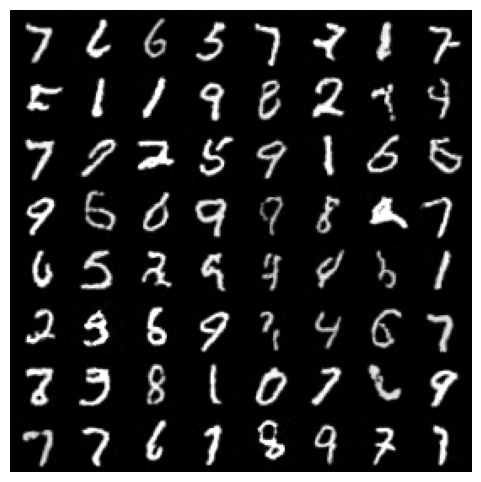

In [8]:
# your existing code
grid = torchvision.utils.make_grid(ddpm_samples, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')

# save to disk
plt.savefig('results/experiment2/images/ddpm_samples.png')

plt.show()

No weights to load
[Checkpoint] Loaded model at epoch 5 from results/experiment2/checkpoints/ddpm_epoch_005.pt
No weights to load
[Checkpoint] Loaded model at epoch 9 from results/experiment2/checkpoints/ddpm_epoch_009.pt
No weights to load
[Checkpoint] Loaded model at epoch 15 from results/experiment2/checkpoints/ddpm_epoch_015.pt
No weights to load
[Checkpoint] Loaded model at epoch 19 from results/experiment2/checkpoints/ddpm_epoch_019.pt


Sampling: 1000it [00:07, 138.15it/s]


Showing/saving samples from epoch 5


Sampling: 1000it [00:06, 156.71it/s]


Showing/saving samples from epoch 9


Sampling: 1000it [00:06, 144.25it/s]


Showing/saving samples from epoch 15


Sampling: 1000it [00:06, 148.10it/s]


Showing/saving samples from epoch 19


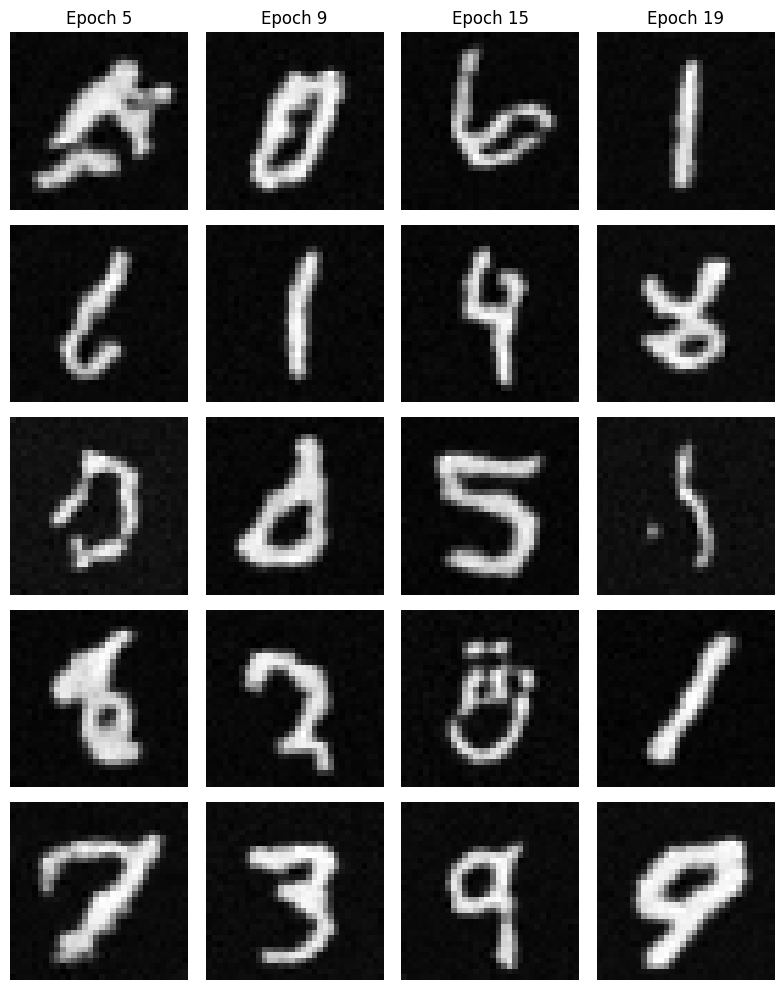

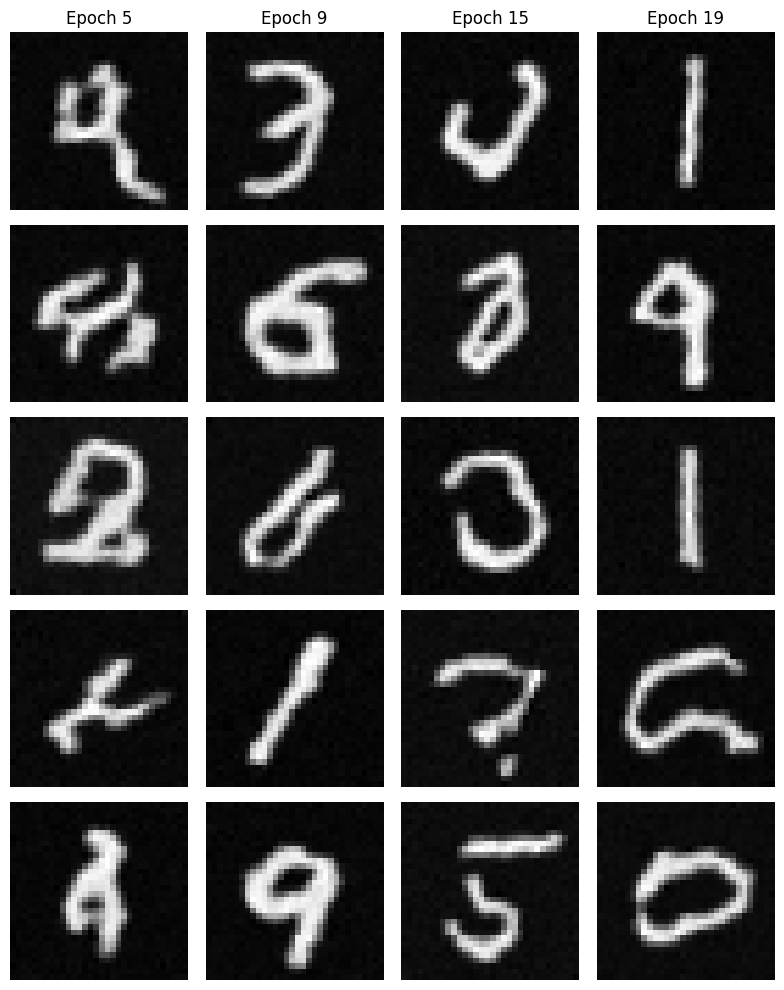

In [9]:
# plot 8 samples each at epochs 5, 10, 15, 20:
plot_samples_across_epochs(
    epochs=[5, 9, 15, 19],
    n_steps=1000,
    file_path='results/experiment2/images/ddpm_samples_across_epochs.png',
    show=True
)

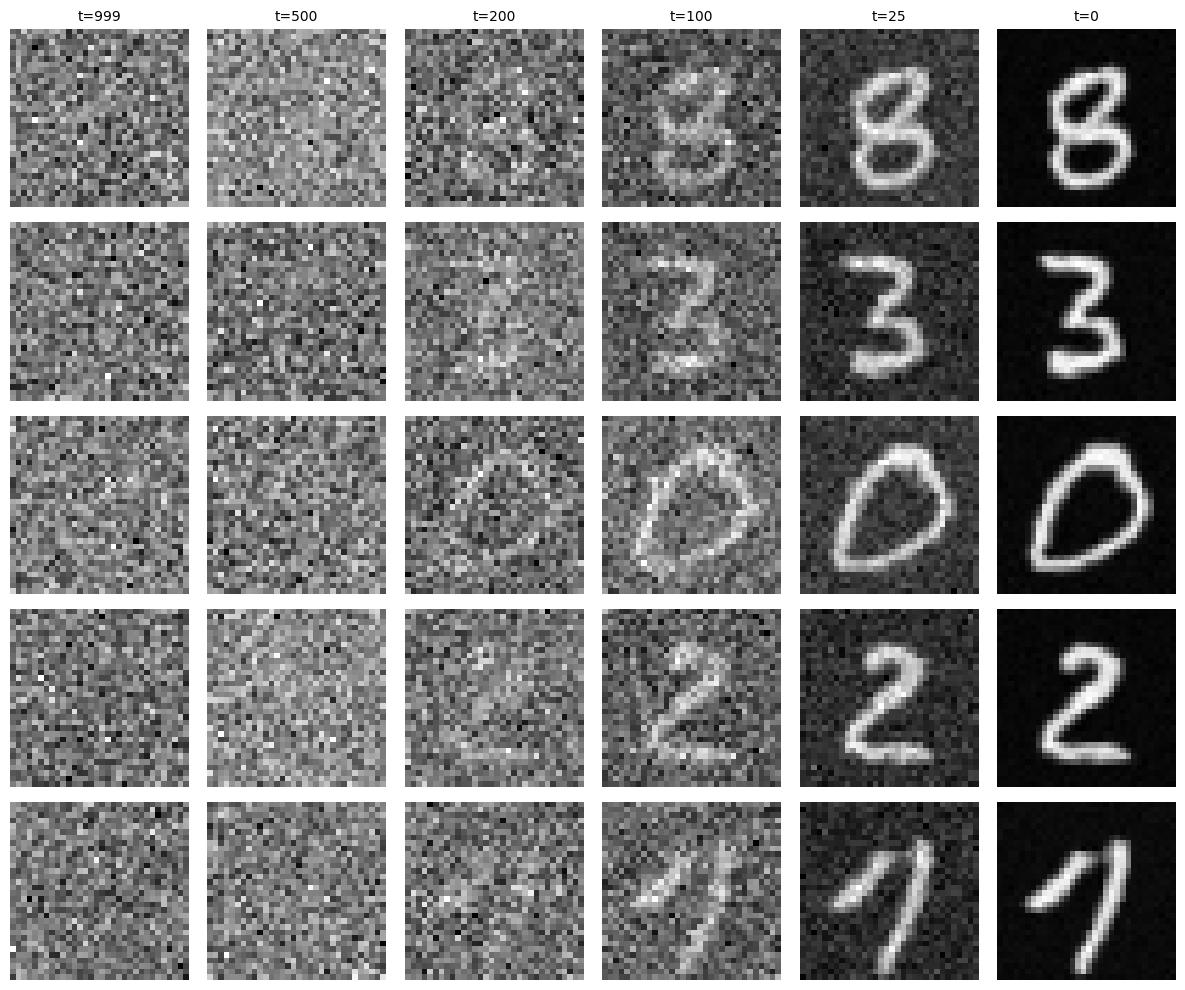

In [24]:
ddpm_intermediate_images = ddpm_trainer.generate_intermediate_samples(
    n_steps=1000,
    steps_to_show=(0, 25, 100, 200, 500, 999),
    n_samples=5,
    file_path='results/experiment2/images/ddpm_intermediate_samples.png',
    show=True
)

## Experiment 3 (CFG)

In [ ]:
cfg_trainer = experiment3(False)

[Checkpoint] Loaded model at epoch 19 from results/experiment3\checkpoints\cfg_epoch_019.pt


In [ ]:
n_samples = 64
labels = torch.randint(0, 9, (n_samples,), device=cfg_trainer.args.device)
n_steps = 1000
cfg_samples = cfg_trainer.sample(n_steps=n_steps, show=True, save=True)

In [ ]:
# your existing code
grid = torchvision.utils.make_grid(ddpm_samples, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')

# save to disk
plt.savefig('results/experiment3/images/cfg_samples.png')

plt.show()

[Checkpoint] Loaded model at epoch 5 from results/experiment3\checkpoints\cfg_epoch_005.pt
[Checkpoint] Loaded model at epoch 5 from results/experiment3\checkpoints\cfg_epoch_005.pt


100it [00:07, 13.68it/s]


Showing/saving samples from epoch 5 with labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[Checkpoint] Loaded model at epoch 9 from results/experiment3\checkpoints\cfg_epoch_009.pt


100it [00:11,  8.88it/s]


Showing/saving samples from epoch 9 with labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[Checkpoint] Loaded model at epoch 15 from results/experiment3\checkpoints\cfg_epoch_015.pt


100it [00:10,  9.49it/s]


Showing/saving samples from epoch 15 with labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[Checkpoint] Loaded model at epoch 19 from results/experiment3\checkpoints\cfg_epoch_019.pt


100it [00:11,  9.03it/s]


Showing/saving samples from epoch 19 with labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


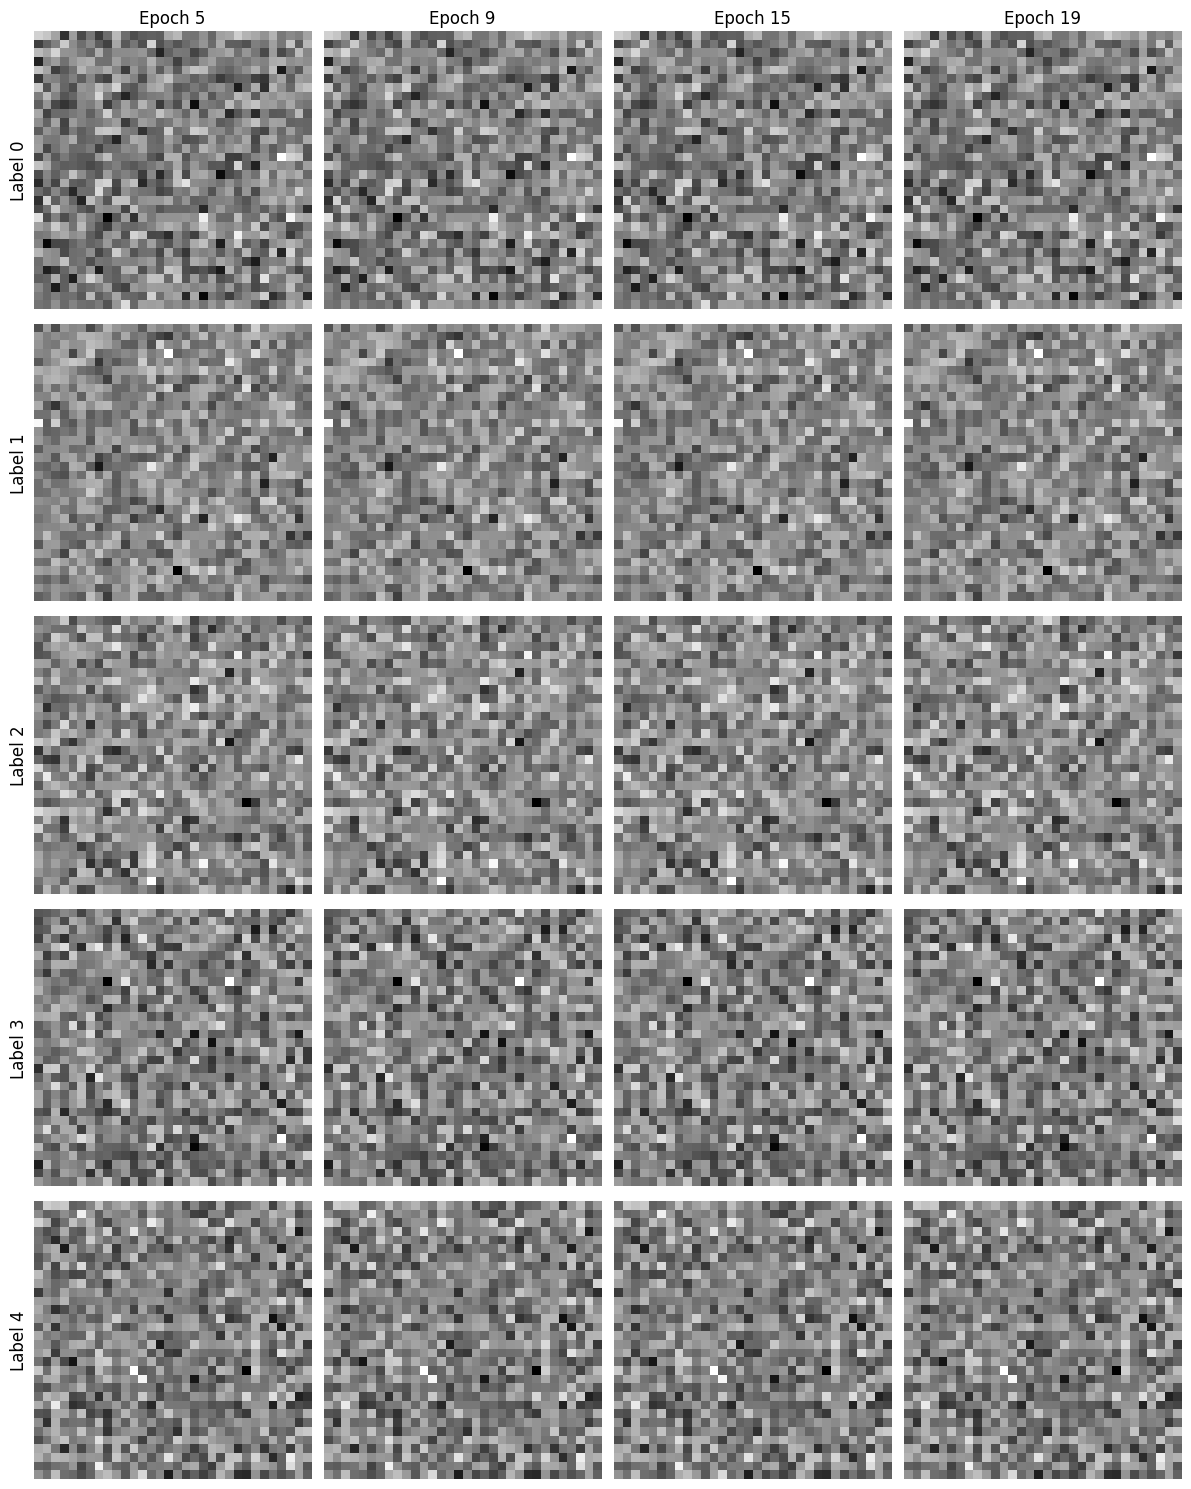

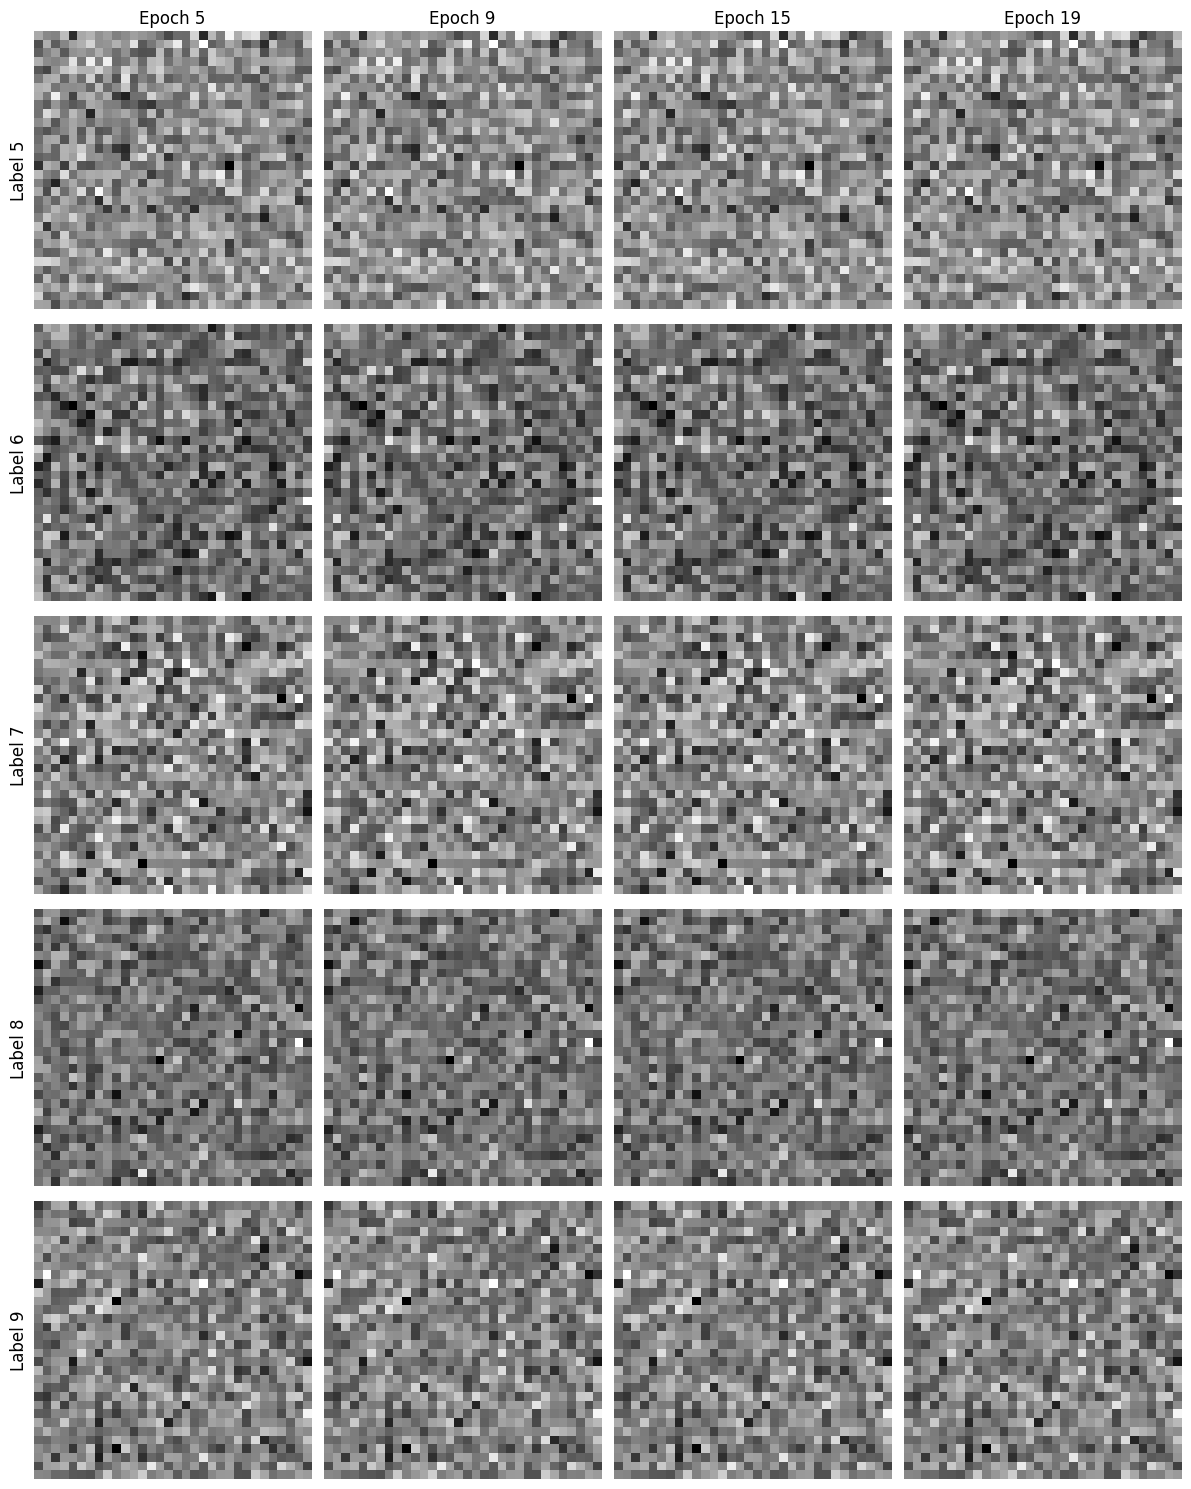

In [ ]:
plot_evolution_across_epochs(
    epochs=[5, 9, 15, 19],
    n_steps=1000,
    show=True,
    file_path='results/experiment3/images/cfg_evolution_across_epochs.png'
)

In [ ]:
make_archive('results', 'zip', 'results')